<a href="https://www.kaggle.com/code/silasemmanuel/ann-and-ga?scriptVersionId=124276866" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Problem Statement**

Financial threats are displaying a trend about the credit risk of commercial banks as the incredible improvement in the financial industry has arisen. In this way, one of the biggest threats faces by commercial banks is the risk prediction of credit clients. The goal is to predict the probability of credit default based on credit card owner's characteristics and payment and ransaction history.

**Approach**

Tasks:- Supervised Learning tasks (Classification Problem)

Environment and Tools.

1. Tensorflow and Keras API.
2. Sklearn.
3. Matplotlib and Seaborn.
4. PyGad

**Table of Content**
1. Importing Dependencies.
2. Data Understanding.
3. Exploratory Data Analysis.
4. Feature Engineering.
5. Model Building.
6. Model Evaluation and Interpretation

In [1]:
!pip install pygad imblearn feature_engine seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 9.5 MB/s eta 0:00:00


# **Importing Dependencies/Libraries**

In [2]:
# data manipulation and utility libraries
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import shapiro

# data visualizition libraries
import seaborn as sns
from matplotlib import pyplot as plt

# sklearn for building precosseing and building ML algorithm.
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, confusion_matrix, 
                             classification_report, precision_score, recall_score, roc_curve)

# importing pygad functions for building geneticsalgorithm.
from pygad import GA
from pygad import gann, nn
from pygad.kerasga import KerasGA, model_weights_as_vector, model_weights_as_matrix, predict
 
# importing the Winsorizer Class from feature engine for handling outlier.
from feature_engine.outliers import Winsorizer

# importing smote and smoteenn for handling imbalance.
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN

# importing tensorflow library for building artificial neural network.
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential, load_model, save_model, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# **Exploratory Data Analysis**

The process of analyzing data is to understand the data and gain useful information so that the derived knowledge can help in decision making.

In [115]:
# loading dataset
df = pd.read_csv('/kaggle/input/fraud-transaction-detection/Final Transactions.csv')

In [116]:
df.head()

,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,0,0
1,1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,0,0
2,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,1,1
3,3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,0,0
4,4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,0,0


In [117]:
# return a tuple representing the dimensionality of the datasets
df.shape

(1754155, 10)

In [118]:
df["TX_DATETIME"] = pd.DatetimeIndex(df["TX_DATETIME"]).year

In [119]:
df.head()

,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0,2023,596,3156,533.07,31,0,0,0
1,1,1,2023,4961,3412,808.56,130,0,0,0
2,2,2,2023,2,1365,1442.94,476,0,1,1
3,3,3,2023,4128,8737,620.65,569,0,0,0
4,4,4,2023,927,9906,490.66,634,0,0,0


In [120]:
# dropping relevant columns
df = df.drop(['Unnamed: 0', 'TX_DATETIME', 'TRANSACTION_ID', 'TX_FRAUD_SCENARIO'], axis = 'columns')

In [121]:
# Count number of distinct elements in specified axis
df.nunique()

CUSTOMER_ID           4990
TERMINAL_ID          10000
TX_AMOUNT           177586
TX_TIME_SECONDS    1635076
TX_TIME_DAYS           183
TX_FRAUD                 2
dtype: int64

In [122]:
# print a concise summary about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   CUSTOMER_ID      int64  
 1   TERMINAL_ID      int64  
 2   TX_AMOUNT        float64
 3   TX_TIME_SECONDS  int64  
 4   TX_TIME_DAYS     int64  
 5   TX_FRAUD         int64  
dtypes: float64(1), int64(5)
memory usage: 80.3 MB


In [123]:
# return the sum of Series denoting duplicate rows.
df.duplicated().sum()

0

In [124]:
# return a Series containing counts of default. 
df['TX_FRAUD'].value_counts()

0    1518186
1     235969
Name: TX_FRAUD, dtype: int64

In [125]:
# return a Series containing counts of default. 
#df['TX_FRAUD_SCENARIO'].value_counts()

In [126]:
# return the total sum of missing values in present in the dataset 
df.isnull().sum()

CUSTOMER_ID        0
TERMINAL_ID        0
TX_AMOUNT          0
TX_TIME_SECONDS    0
TX_TIME_DAYS       0
TX_FRAUD           0
dtype: int64

In [127]:
# generate descriptive statistics of the dataset.
df.describe().round(3)

,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD
count,1754155.000,1754155.000,1754155.000,1.754155e+06,1754155.000,1754155.000
mean,2504.011,4996.733,539.682,7.903234e+06,90.973,0.135
std,1445.987,2886.101,1179.711,4.565172e+06,52.837,0.341
min,0.000,0.000,0.000,3.100000e+01,0.000,0.000
25%,1252.000,2502.000,179.950,3.940846e+06,45.000,0.000
50%,2506.000,4994.000,421.750,7.902670e+06,91.000,0.000
75%,3765.000,7495.000,750.595,1.186566e+07,137.000,0.000
max,4999.000,9999.000,647837.500,1.581120e+07,182.000,1.000


In [128]:
# checking relationship i.e correlation of variable in the dataset
corr = df.corr()
corr

,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD
CUSTOMER_ID,1.000000,0.000389,-0.002633,-0.000389,-0.000389,0.004353
TERMINAL_ID,0.000389,1.000000,-0.000758,-0.000690,-0.000690,-0.002160
TX_AMOUNT,-0.002633,-0.000758,1.000000,0.002453,0.002449,0.313427
TX_TIME_SECONDS,-0.000389,-0.000690,0.002453,1.000000,0.999992,0.002650
TX_TIME_DAYS,-0.000389,-0.000690,0.002449,0.999992,1.000000,0.002650
TX_FRAUD,0.004353,-0.002160,0.313427,0.002650,0.002650,1.000000


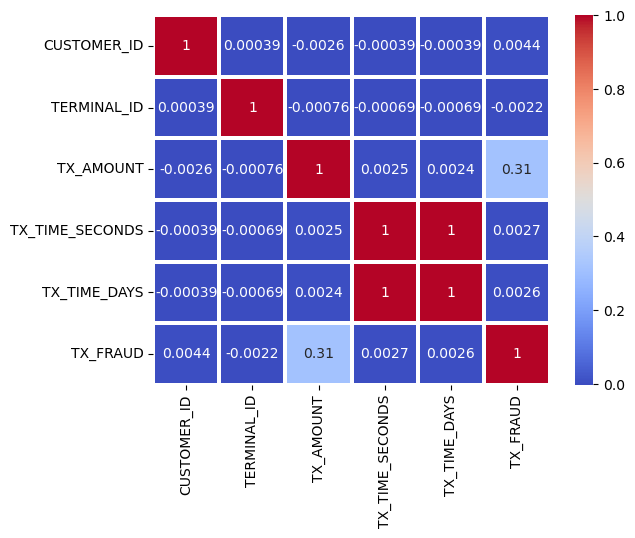

In [129]:
# checking correlation in heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=1.5)
plt.show()

**Calculating the mutual information of each variable**

Text(0.5, 1.0, 'Mutual Information Scores')

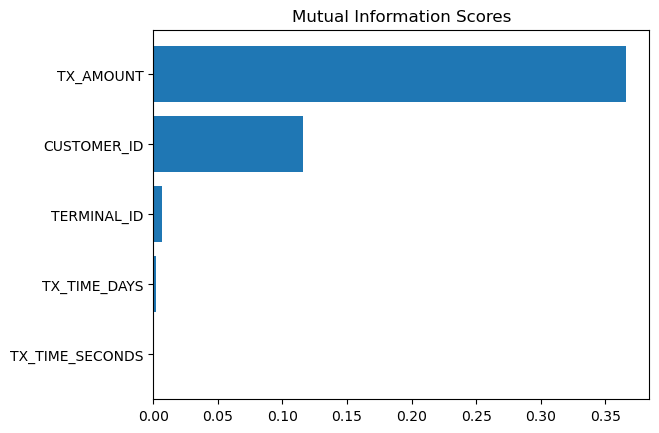

In [130]:
# using mutual info classif to calculate the mutual information of each independent variable
mi_scores = mutual_info_classif(df.drop(['TX_FRAUD'], axis = 1), df['TX_FRAUD'], random_state = 0)
mi_scores = pd.Series(mi_scores, name = 'MI Scores', index = df.drop('TX_FRAUD', axis = 1).columns)

mi_scores = mi_scores.sort_values(ascending = True)
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")

**NOTE:**

The customer transaction dataset is highly skewed. **Skew** can be seen as a distortion froma normal distribution. Make use of **histplot function from seanborn** library to plot a distribution of the amount column in the dataset. discover that amount column is heavily skewed to the left side and could cause the neural network algorithm to trained on a much larger number of moderately customer transaction amount, and will be less likely  to successfully predict the customer with much larger amount.

So we can use of the **Shapiro** which was imported using the command "from scipy.stats import shapiro". Shapiro is a statistical test that is used to check whether a data is normally distributed or not.

.

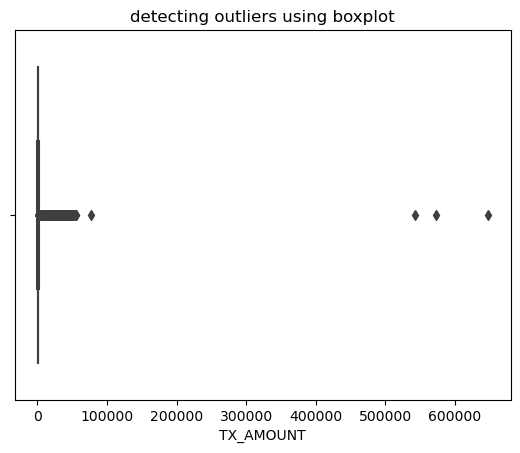

In [131]:
# detecting outliers using boxplot
plt.title('detecting outliers using boxplot')
sns.boxplot(x='TX_AMOUNT', data=df)
plt.show()

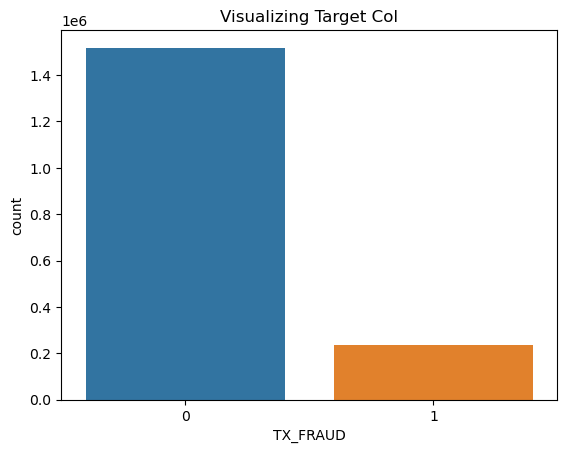

In [132]:
# plotting target col
plt.title('Visualizing Target Col')
sns.countplot(x='TX_FRAUD', data=df)
plt.show()

**Detecting Skewness using the Shapiro-Wilks-Test from Scipy Package**



In [133]:
# created a variable called resp to hold the amount values
resp = df.TX_AMOUNT

In [134]:
# Perform the Shapiro-Wilk test for normality.
shapiro(resp)

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.17178833484649658, pvalue=0.0)

H0 (Null): Sample is from normal distribution. (P>0.05)

H1 (Alternative): Sample is not from normal distribution.


**Output Interpretation**

Since in the above diagram, the p-value is 0.0 which is less than alpha (0.05) 
then we reject the null hypothesis i.e. we have sufficient evidence to say that sample does not come from a normal distribution.

**Performing Feature Engineering**

In [135]:
# assign independent variables 
x = df.drop(['TX_FRAUD'], axis=1)
# assign dependent variable
y = df['TX_FRAUD']

# **Splitting Dataset into Training and Testing Set**

In [136]:
# Split arrays or matrices into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=52)

In [137]:
# checking the spread of data
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1227908, 5)
(526247, 5)
(1227908,)
(526247,)


In [138]:
# checking the shape of the x_train
print(x_train.shape)
# features that will be usd for training
print(x_train)

(1227908, 5)
         CUSTOMER_ID  TERMINAL_ID  TX_AMOUNT  TX_TIME_SECONDS  TX_TIME_DAYS
145539          2411          181     278.41          1322302            15
1595357         4819         6748     464.52         14382641           166
1377501         3100         3162    1134.89         12408574           143
689578           752         7061      95.13          6202371            71
1731820         1528         1800     914.96         15603537           180
...              ...          ...        ...              ...           ...
786577          1534         6672     998.71          7092618            82
1208948         3469         8413      94.05         10904933           126
605317           742         2160     171.41          5463342            63
376542          2314         5341     907.48          3398737            39
510165          3393         7669     230.68          4602290            53

[1227908 rows x 5 columns]


In [139]:
# checking the shape of the y_train
print(y_train.shape)
# target label that will be use during training
print(y_train)

(1227908,)
145539     0
1595357    0
1377501    1
689578     0
1731820    0
          ..
786577     0
1208948    0
605317     0
376542     0
510165     0
Name: TX_FRAUD, Length: 1227908, dtype: int64


In [140]:
# checking the shape of the x_test
print(x_test.shape)
# the unseen data that will be used for evaluation
print(x_test)

(526247, 5)
         CUSTOMER_ID  TERMINAL_ID  TX_AMOUNT  TX_TIME_SECONDS  TX_TIME_DAYS
1365858         2040         1094     807.95         12310504           142
1233222         1168         6403      15.19         11109491           128
926363           688         1036     835.92          8339539            96
1025664         2490         2314     747.30          9234104           106
1481708         3807          183     274.79         13354163           154
...              ...          ...        ...              ...           ...
1429378          584         1882     593.27         12893276           149
891923          1220         6831    1295.72          8027465            92
118074           521         5840    1267.63          1070909            12
75168           2807          404     450.87           668849             7
768873          2084         5454     268.04          6936316            80

[526247 rows x 5 columns]


In [141]:
# checking the shape of the y_test
print(y_test.shape)
# actual value that will be use to evaluate
# model predict value
print(y_test)

(526247,)
1365858    0
1233222    0
926363     0
1025664    0
1481708    0
          ..
1429378    0
891923     1
118074     1
75168      0
768873     0
Name: TX_FRAUD, Length: 526247, dtype: int64


**Feature Scaling**

In [142]:
# Transform features by scaling each feature to a given range.
mn = MinMaxScaler()

# Fit to data, then transform it. the training datasets
x_train = mn.fit_transform(x_train)
# Perform standardization by centering and scaling on the testing datasets                
x_test = mn.transform(x_test)                                                   

**Model Development**

TensorFlow is an open-sourced end-to-end platform, a library for multiple machine learning tasks, 
while Keras is a high-level neural network library that runs on top of TensorFlow

In [143]:
# building keras model
def build_model():
    # Sequential groups a linear stack of layers
    model = Sequential([
        Dense(128, activation="relu", input_shape=(5,), kernel_initializer='he_uniform'),
        Dense(64, activation="relu"),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    
    return model
model = build_model() 

In [144]:
# Prints a string summary of the network.
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               768       
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 128)               8320      
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 25,665
Trainable params: 25,665
Non-trainable params: 0
_________________________________________________________________


In [145]:
# Configures the model for training.
model.compile(
    # Gradient descent (with momentum) optimizer.
    optimizer=Adam(learning_rate=0.001),
    # Computes the cross-entropy loss between true labels and predicted labels.
    loss=BinaryCrossentropy(),
    # Calculates how often predictions match binary labels.
    metrics=[BinaryAccuracy()],
)

In [146]:
# Stop training when a monitored metric has stopped improving.
callback = EarlyStopping(monitor='loss', patience=3)

In [147]:
# Trains the model for a fixed number of epochs (iterations on a dataset).
history = model.fit(x_train, y_train, batch_size=64, epochs=30, callbacks=[callback],
                    validation_data=(x_test, y_test))

# Returns the loss value & metrics values for the model in train mode.
_, acc = model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy: {:.2f}".format(acc*100))

# Returns the loss value & metrics values for the model in test mode.
_, acc = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: {:.2f}".format(acc*100))

Epoch 1/30
19187/19187 [==============================] - 84s 4ms/step - loss: 0.1717 - binary_accuracy: 0.9391 - val_loss: 0.1446 - val_binary_accuracy: 0.9462
Epoch 2/30
19187/19187 [==============================] - 82s 4ms/step - loss: 0.0886 - binary_accuracy: 0.9695 - val_loss: 0.1220 - val_binary_accuracy: 0.9504
Epoch 3/30
19187/19187 [==============================] - 82s 4ms/step - loss: 0.0798 - binary_accuracy: 0.9732 - val_loss: 0.1119 - val_binary_accuracy: 0.9555
Epoch 4/30
19187/19187 [==============================] - 82s 4ms/step - loss: 0.0733 - binary_accuracy: 0.9761 - val_loss: 0.4232 - val_binary_accuracy: 0.8945
Epoch 5/30
19187/19187 [==============================] - 87s 5ms/step - loss: 0.0691 - binary_accuracy: 0.9780 - val_loss: 0.0563 - val_binary_accuracy: 0.9831
Epoch 6/30
19187/19187 [==============================] - 88s 5ms/step - loss: 0.0651 - binary_accuracy: 0.9797 - val_loss: 0.0475 - val_binary_accuracy: 0.9897
Epoch 7/30
19187/19187 [==========

# **Model Testing and Evaluation on Original Dataset**

Tested the model performance unseen dataset. Then evaluate the performance using the following metrics: -

1. Precision
2. Recall
3. F1-score
4. Classification Report
5. Confusion Matrix
6. AUC (area under curve)

In [148]:
# Generates output predictions for the x_test input sample.
pred = model.predict(x_test, batch_size=128)

4112/4112 [==============================] - 7s 2ms/step


In [149]:
y_hat = [1 if i > 0.5 else 0 for i in pred]

In [150]:
# Compute the precision.

# The precision is the ratio "tp / (tp + fp)" where "tp" is the number of
# true positives and "fp" the number of false positives. 

print("Precision score: {:.2f}".format(precision_score(y_test, y_hat)))

Precision score: 0.97


In [151]:
# Compute the recall.

# The recall is the ratio "tp / (tp + fn)" where "tp" is the number of
# true positives and "fn" the number of false negatives. 
 
print("Recall score: {:.2f}".format(recall_score(y_test, y_hat)))

Recall score: 0.96


In [152]:
# Compute the F1 score, also known as balanced F-score or F-measure
# The F1 score can be interpreted as a harmonic mean of the precision and
# recall, where an F1 score reaches its best value at 1 and worst score at 0.

print("F1-score: {:.2f}".format(f1_score(y_test, y_hat)))

F1-score: 0.97


In [153]:
# Build a text report showing the main classification metrics.
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    455456
           1       0.97      0.96      0.97     70791

    accuracy                           0.99    526247
   macro avg       0.98      0.98      0.98    526247
weighted avg       0.99      0.99      0.99    526247



In [154]:
# Compute confusion matrix to evaluate the accuracy of a classification.
con_matrix = pd.DataFrame(confusion_matrix(y_test, y_hat), 
                          index=["Actual: No", "Actual: Yes"],
                          columns=("Predicted: No", "Predicted: Yes"))
print(con_matrix)

             Predicted: No  Predicted: Yes
Actual: No          453229            2227
Actual: Yes           2498           68293


In [155]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) score for test data.
print('ROC AUC score: {0:0.4f}'.format(roc_auc_score(y_test, y_hat)))

ROC AUC score: 0.9799


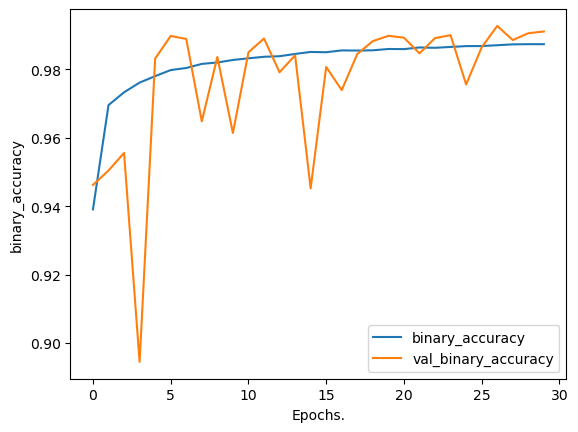

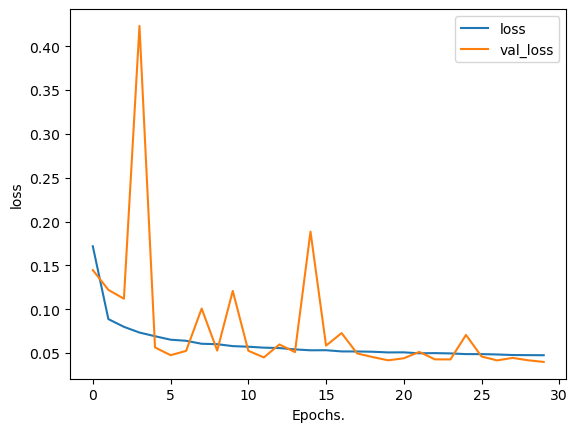

In [156]:
# plotting model peformance
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs.")
    plt.ylabel(string)
    plt.legend([string, "val_"+string])
    plt.show()

# Model Accuracy Performance 
plot_graph(history, "binary_accuracy")
# Model Validation Performance
plot_graph(history, "loss")

# **Model Development with the Over-sample Dataset**

During the model training performance the following tasks:- 

1. Split dataset
2. Removed outliers using the winsorizer library
3. Over-sample data using SMOTEENN to handle class imbalance
4. Scale data using standard scaler
5. Train model
6. Test and evaluate model

# **Splitting Dataset into Training and Testing Set**

In [157]:
# Split arrays or matrices into random train and test subsets.
xtrain, xtest, ytrain, ytest = train_test_split(x, y, stratify=y, test_size=0.3, random_state=52)

In [158]:
# checking the spread of data
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(1227908, 5)
(526247, 5)
(1227908,)
(526247,)


In [159]:
# lets select the numerical columns 
num_cols = xtrain.select_dtypes(include = np.number).columns

num_cols

Index(['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_TIME_SECONDS',
       'TX_TIME_DAYS'],
      dtype='object')

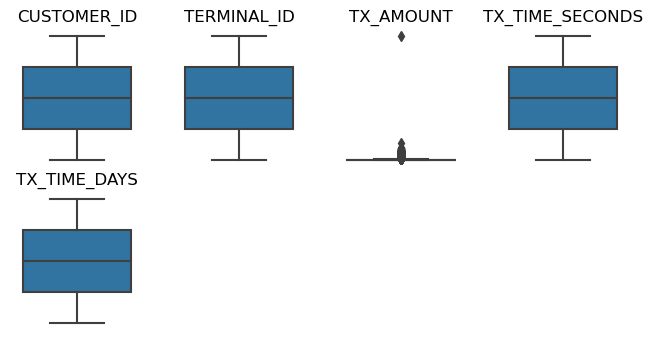

In [160]:
# plotting the features to display features with outliers.
# from the diagram below we can see that the amount and the fraud screnario columns have outliers.

plt.figure(figsize = [8,6])

for ind,col_name in enumerate(num_cols):
  plot_var = xtrain[col_name]
  plt.subplot(3, 4,ind+1)
  sns.boxplot(plot_var)
  plt.title(col_name)
  plt.axis(False)

**Making use of the Winsorizer library imported from feature_engineer to treat outliers**

In [161]:
# variables to be handled with the outlier
variables = ['TX_AMOUNT'] 
# choosing the IQR method with fold = 1.5 time of IQR
capper_iqr = Winsorizer(capping_method = 'iqr', tail = 'both', fold = 1.5, variables = variables) 

# configure the winsorizer to make use of inter-quantile-range to treate outlier.
 # right tail: 75th quantile + 3* IQR
 # left tail:  25th quantile - 3* IQR

# where IQR is the inter-quartile range: 75th quantile - 25th quantile.

In [162]:
# Fit to data, then transform it.
xtrain = capper_iqr.fit_transform(xtrain) 
# tranforming the test X
xtest = capper_iqr.transform(xtest) 

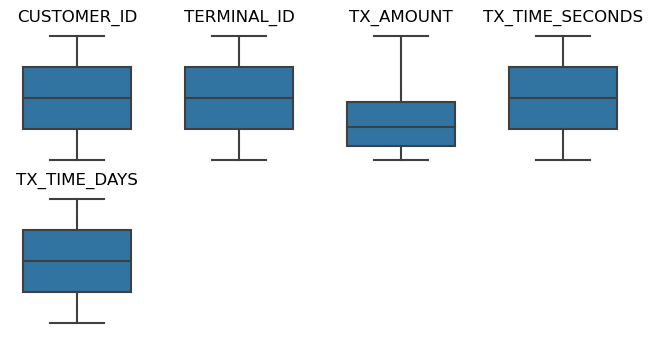

In [163]:
# displaying variables after handling the outlier.
# from the diagram we can see we do not have variable with outliers present in the dataset.

plt.figure(figsize = [8,6])

for ind,col_name in enumerate(num_cols):
  plot_var = xtrain[col_name]
  plt.subplot(3, 4,ind+1)
  sns.boxplot(plot_var)
  plt.title(col_name)
  plt.axis(False)

**Using Imblearn Library to Handle Data Imbalance present in the Dataset.**

Use the Synthetic Minority Oversampling Technique Edited Nearest Neighbours (SMOTEENN) which is a statistical technique for increasing the number of cases in your dataset in a balanced way.

In [164]:
# outputing y value before over sampling.
counter = Counter(ytrain)
print("Before Sampling: {}".format(counter))

# Oversample using Adaptive Synthetic (ADASYN) algorithm.
sm = ADASYN()
# esample the dataset.
xtrain_sm, ytrain_sm = sm.fit_resample(xtrain, ytrain)

# outputing y value after over sampling.
counter = Counter(ytrain_sm)
print("After Sampling: {}".format(counter))

Before Sampling: Counter({0: 1062730, 1: 165178})
After Sampling: Counter({1: 1100017, 0: 1062730})


**Feature Scaling**

In [165]:
# Transform features by scaling each feature to a given range.
mn = MinMaxScaler()

# Fit to data, then transform it. the training datasets
xtrain_sm = mn.fit_transform(xtrain_sm)
# Perform standardization by centering and scaling on the testing datasets                
xtest = mn.transform(xtest)                                                   

**Model Development**

TensorFlow is an open-sourced end-to-end platform, a library for multiple machine learning tasks, 
while Keras is a high-level neural network library that runs on top of TensorFlow

In [166]:
# building keras model
def build_model():
    # Sequential groups a linear stack of layers
    model = Sequential([
        Dense(32, activation="relu", input_shape=(5,)),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    return model
model = build_model()

In [167]:
# Prints a string summary of the network.
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 32)                192       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64)               

In [168]:
# Configures the model for training.
model.compile(
 # Gradient descent (with momentum) optimizer.
optimizer=Adam(learning_rate=0.001),
# Computes the cross-entropy loss between true labels and predicted labels.
loss=BinaryCrossentropy(),
# Calculates how often predictions match binary labels.
metrics=[BinaryAccuracy()],
# number of batches to run during each call
steps_per_execution=32
)

In [169]:
# Stop training when a monitored metric has stopped improving.
callback = EarlyStopping(monitor='loss', patience=5)

In [170]:
# Trains the model for a fixed number of epochs (iterations on a dataset).
history = model.fit(xtrain_sm, ytrain_sm, batch_size=64, epochs=30, callbacks=[callback],
                    validation_data=(xtest, ytest), steps_per_epoch=16)

# Returns the loss value & metrics values for the model in train mode.
_, acc = model.evaluate(xtrain_sm, ytrain_sm, verbose=0)
print("Train Accuracy: {:.2f}".format(acc*100))

# Returns the loss value & metrics values for the model in test mode.
_, acc = model.evaluate(xtest, ytest, verbose=0)
print("Test Accuracy: {:.2f}".format(acc*100))

Epoch 1/30
16/16 [==============================] - 13s 813ms/step - loss: 0.6554 - binary_accuracy: 0.5605 - val_loss: 0.7383 - val_binary_accuracy: 0.2923
Epoch 2/30
16/16 [==============================] - 9s 581ms/step - loss: 0.5630 - binary_accuracy: 0.7363 - val_loss: 0.5498 - val_binary_accuracy: 0.8027
Epoch 3/30
16/16 [==============================] - 10s 644ms/step - loss: 0.3938 - binary_accuracy: 0.8779 - val_loss: 0.3345 - val_binary_accuracy: 0.8712
Epoch 4/30
16/16 [==============================] - 9s 580ms/step - loss: 0.2880 - binary_accuracy: 0.8887 - val_loss: 0.2661 - val_binary_accuracy: 0.8841
Epoch 5/30
16/16 [==============================] - 10s 644ms/step - loss: 0.2711 - binary_accuracy: 0.8926 - val_loss: 0.1792 - val_binary_accuracy: 0.9250
Epoch 6/30
16/16 [==============================] - 9s 568ms/step - loss: 0.2130 - binary_accuracy: 0.9160 - val_loss: 0.1556 - val_binary_accuracy: 0.9381
Epoch 7/30
16/16 [==============================] - 9s 577ms/

# **Model Testing and Evaluation on Original Dataset**

Tested the model performance unseen dataset. Then evaluate the performance using the following metrics: -

1. Precision
2. Recall
3. F1-score
4. Classification Report
5. Confusion Matrix
6. AUC (area under curve)

In [171]:
# Generates output predictions for the x_test input sample.
prediction = model.predict(xtest, batch_size=128)

4112/4112 [==============================] - 4s 898us/step


In [172]:
y_pred = [1 if i > 0.5 else 0 for i in prediction]

In [173]:
# Compute the precision.

# The precision is the ratio "tp / (tp + fp)" where "tp" is the number of
# true positives and "fp" the number of false positives. 

print("Precision score: {:.2f}".format(precision_score(ytest, y_pred)))

Precision score: 0.94


In [174]:
# Compute the recall.

# The recall is the ratio "tp / (tp + fn)" where "tp" is the number of
# true positives and "fn" the number of false negatives. 
 
print("Recall score: {:.2f}".format(recall_score(ytest, y_pred)))

Recall score: 0.93


In [175]:
# Compute the F1 score, also known as balanced F-score or F-measure
# The F1 score can be interpreted as a harmonic mean of the precision and
# recall, where an F1 score reaches its best value at 1 and worst score at 0.

print("F1-score: {:.2f}".format(f1_score(ytest, y_pred)))

F1-score: 0.93


In [176]:
# Build a text report showing the main classification metrics.
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    455456
           1       0.94      0.93      0.93     70791

    accuracy                           0.98    526247
   macro avg       0.97      0.96      0.96    526247
weighted avg       0.98      0.98      0.98    526247



In [177]:
# Compute confusion matrix to evaluate the accuracy of a classification.
con_matrix = pd.DataFrame(confusion_matrix(ytest, y_pred), 
                          index=["Actual: No", "Actual: Yes"],
                          columns=("Predicted: No", "Predicted: Yes"))
print(con_matrix)

             Predicted: No  Predicted: Yes
Actual: No          451515            3941
Actual: Yes           5252           65539


In [178]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) score for test data.
print('ROC AUC score: {:.2f}'.format(roc_auc_score(ytest, y_pred)))

ROC AUC score: 0.96


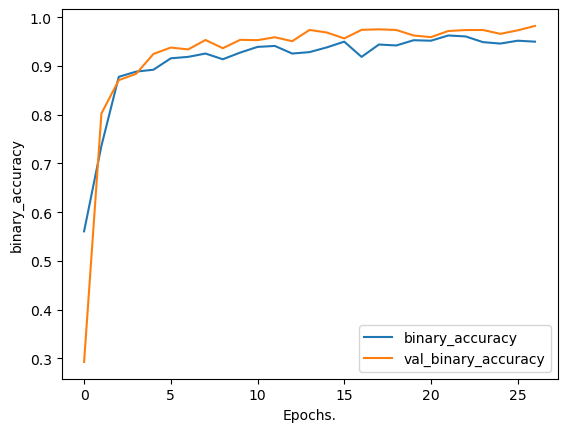

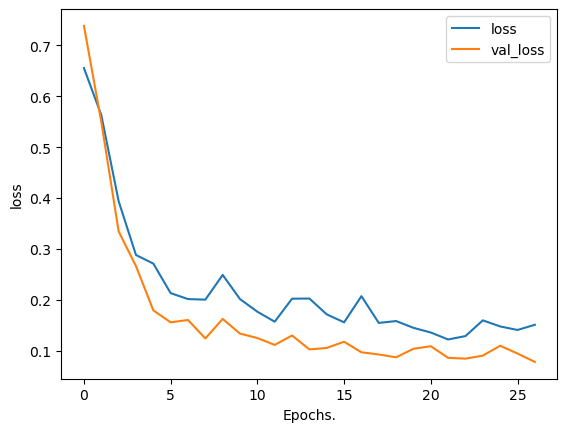

In [179]:
# plotting model peformance
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs.")
    plt.ylabel(string)
    plt.legend([string, "val_"+string])
    plt.show()

# Model Accuracy Performance 
plot_graph(history, "binary_accuracy")
# Model Validation Performance
plot_graph(history, "loss")

# **Genetics Algorithm and Neural Network.**

**Using the PyGad library which we used to build genetics algorithm, it also provide support for tensorflow keras.**

**The following steps were perform:**

1. Prepare the training data.
2. Create a keras model.
3. Build the fitness function.
4. Configure the necessary parameter for pygad function GA.
5. Run the genetic algorithm.

In [180]:
# assign x_train to data_input
data_input = xtrain_sm
# assign y_train to data_output
data_output = ytrain_sm.values
print(data_input.shape)
print(data_output.shape)

(2162747, 5)
(2162747,)


In [181]:
import numpy 
# creating fitness function
def fitness_fuc(solution, sol_idx):
    global GANN_instance, data_input, data_output
    
    prediction = nn.predict(last_layer=GANN_instance.population_networks[sol_idx], 
                            data_inputs=data_input)
    
    correct_prediction = numpy.where(prediction == data_output)[0].size
    solution_fitness = (correct_prediction/data_output.size)*100
    
    return solution_fitness

# The fitness function must return a single number representing the fitness. 
# The higher the fitness value, the better the solution.

In [182]:
# creating callback function
# callback function is used to update the trained_weights attribute of layers of each network in the population.
def callback_genetion(ga_instance):
    global GANN_instance
    
    population_matrices = gann.population_as_matrices(population_networks=GANN_instance.population_networks, 
                                                      population_vectors=ga_instance.population)
    
    GANN_instance.update_population_trained_weights(population_trained_weights=population_matrices)
    
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [183]:
# Creating GANN class for training a neural network using the genetic
GANN_instance = gann.GANN(num_solutions=10, 
                          num_neurons_input=data_input.shape[1], 
                          num_neurons_hidden_layers=[16, 32],
                          num_neurons_output=2,
                          hidden_activations=['relu', 'relu'],
                          output_activation='sigmoid')

# Accepts the population as networks and returns a list holding all weights of the 
# layers of each solution (i.e. network) in the population as a vector.
population_vectors = gann.population_as_vectors(population_networks=GANN_instance.population_networks)

In [184]:
# Configuring the parameters required to create an instance of the GA class.
ga_instance = GA(num_generations=15,
                 num_parents_mating=4,
                 fitness_func=fitness_fuc,
                 initial_population=population_vectors.copy(),
                 parent_selection_type='tournament',
                 keep_parents = -1,
                 K_tournament=4,
                 crossover_probability= 1,
                 crossover_type = "uniform",
                 mutation_percent_genes=10,
                 callback_generation=callback_genetion)

/opt/conda/lib/python3.7/site-packages/pygad/pygad.py:860: UserWarning: Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.
  if not self.suppress_warnings: warnings.warn("Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.")


In [185]:
# Runs the genetic algorithm
ga_instance.run()

Generation = 1
Fitness = 65.5383639417833
Generation = 2
Fitness = 77.19876619872782
Generation = 3
Fitness = 77.19876619872782


KeyboardInterrupt: 

In [ ]:
# Creates, shows, and returns a figure that summarizes how the fitness value evolved by generation
ga_instance.plot_fitness()

In [ ]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

In [ ]:
# Predicting the outputs of the data using the best solution.
prediction = nn.predict(last_layer=GANN_instance.population_networks[solution_idx],
                        data_inputs=data_input)

In [ ]:
# Calculating some statistics
num_wrong = numpy.where(prediction != data_output)[0]
num_correct = data_output.size - num_wrong.size
accuracy = 100 * (num_correct/data_output.size)

print("Number of correct classifications : {num_correct}.".format(num_correct=num_correct))
print("Number of wrong classifications : {num_wrong}.".format(num_wrong=num_wrong.size))
print("Classification accuracy : {accuracy}.".format(accuracy=accuracy))

# **Model Testing and Evaluation on Hybrid Algorithm.**

Used unseen dataset to test the hybrid model performance. Then evaluate the performance using the following metrics: -

1. Precision
2. Recall
3. F1-score
4. Classification Report
5. Confusion Matrix
6. AUC (area under curve)

In [ ]:
# Compute the precision.

# The precision is the ratio "tp / (tp + fp)" where "tp" is the number of
# true positives and "fp" the number of false positives. 

print("Precision score: {:.2f}".format(precision_score(data_output, prediction))

In [ ]:
# Compute the recall.

# The recall is the ratio "tp / (tp + fn)" where "tp" is the number of
# true positives and "fn" the number of false negatives. 
 
print("Recall score: {:.2f}".format(recall_score(data_output, prediction)))

In [ ]:
# Compute the F1 score, also known as balanced F-score or F-measure
# The F1 score can be interpreted as a harmonic mean of the precision and
# recall, where an F1 score reaches its best value at 1 and worst score at 0.

print("F1-score: {:.2f}".format(f1_score(data_output, prediction)))

In [ ]:
# Build a text report showing the main classification metrics.
print(classification_report(data_output, prediction))

In [ ]:
# Compute confusion matrix to evaluate the accuracy of a classification.
con_matrix = pd.DataFrame(confusion_matrix(data_output, prediction), 
                          index=["Actual: No", "Actual: Yes"],
                          columns=("Predicted: No", "Predicted: Yes"))
print(con_matrix)

In [ ]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) score for test data.
print('ROC AUC score: {:.2f}'.format(roc_auc_score(data_output, prediction)))

In [ ]:
pd.DataFrame(data=[[0.53, 0.17, 0.53], [0.58, 0.72, 0.54]], index=['Neural Network', 'Genetic Algorithm and Neural Network'], columns=['Accuracy', 'F1-Score', 'AUC Score'])